# MobileNetV2

End-to-end MobileNetV2 training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

## CassavaDiseaseDataset

In [2]:
TRAIN_DIR = 'dataset/cassava/train'
TEST_DIR = 'dataset/cassava/test'

In [3]:
classes = os.listdir(TRAIN_DIR)
print(classes)

['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']


Reading the images and storing them into a list

In [4]:
train_dataset = []
class_count = 0
dimension = (224, 224)

for leaf_class in classes:
    img_list = [f'{TRAIN_DIR}/{leaf_class}/{img}' for img in os.listdir(f'{TRAIN_DIR}/{leaf_class}')]
    
    for img_path in tqdm(img_list):  
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, dimension, interpolation = cv2.INTER_AREA)
        img = img_to_array(img)
        img = img / 255
        
        train_dataset.append([img, class_count])
        
    class_count += 1
    
test_dataset = []
class_count = 0
dimension = (224, 224)

for leaf_class in classes:
    img_list = [f'{TEST_DIR}/{leaf_class}/{img}' for img in os.listdir(f'{TEST_DIR}/{leaf_class}')]
    
    for img_path in tqdm(img_list):  
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, dimension, interpolation = cv2.INTER_AREA)
        img = img_to_array(img)
        img = img / 255
        
        test_dataset.append([img, class_count])
        
    class_count += 1

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/1533 [00:00<?, ?it/s]

  0%|          | 0/1671 [00:00<?, ?it/s]

  0%|          | 0/9211 [00:00<?, ?it/s]

  0%|          | 0/1804 [00:00<?, ?it/s]

  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/715 [00:00<?, ?it/s]

  0%|          | 0/3947 [00:00<?, ?it/s]

  0%|          | 0/773 [00:00<?, ?it/s]

In [6]:
print("train: " + str(len(train_dataset)))
print("test: " + str(len(test_dataset)))

train: 14980
test: 6417


In [7]:
train_data, train_labels = zip(*train_dataset)
test_data, test_labels = zip(*test_dataset)

In [8]:
data = np.array(train_data)
labels = to_categorical(train_labels)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.3, random_state = 42)

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10486, 224, 224, 3)
(4494, 224, 224, 3)
(10486, 5)
(4494, 5)


The testing data will be used for testing after training the model

In [11]:
testX = np.array(test_data)
testy = to_categorical(test_labels)

In [12]:
print(testX.shape)
print(testy.shape)

(6417, 224, 224, 3)
(6417, 5)


## Model Training without Data Augmentation

In [13]:
from tensorflow.keras.applications import MobileNetV2

In [14]:
pretrained_model = MobileNetV2(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
pretrained_model.trainable = True

In [16]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(6, activation = 'relu')(pretrained_model.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(5, activation = 'softmax')(x)
model = tf.keras.Model(inputs = inputs, outputs = outputs)

model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [17]:
# Reduce learning rate when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', mode = 'max',
                                                 min_delta = 0.01, patience = 3,
                                                 factor = 0.25, verbose = 1,
                                                 cooldown = 0, min_lr = 0.0001)

# Stop the training process when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max',
                                                 min_delta = 0.005, patience = 10,
                                                 verbose = 1, restore_best_weights = True)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 30, callbacks = [early_stopper, reduce_lr])

Epoch 1/30
328/328 [==============================] - 907s 3s/step - loss: 0.9551 - accuracy: 0.6529 - val_loss: 2.5097 - val_accuracy: 0.6226 - lr: 0.0010
Epoch 2/30
328/328 [==============================] - 820s 3s/step - loss: 0.7248 - accuracy: 0.7363 - val_loss: 1.4968 - val_accuracy: 0.3594 - lr: 0.0010
Epoch 3/30
328/328 [==============================] - 817s 2s/step - loss: 0.6125 - accuracy: 0.7814 - val_loss: 2.3633 - val_accuracy: 0.1400 - lr: 0.0010
Epoch 4/30
328/328 [==============================] - ETA: 0s - loss: 0.5387 - accuracy: 0.8069
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
328/328 [==============================] - 816s 2s/step - loss: 0.5387 - accuracy: 0.8069 - val_loss: 5.2894 - val_accuracy: 0.1077 - lr: 0.0010
Epoch 5/30
328/328 [==============================] - 816s 2s/step - loss: 0.3913 - accuracy: 0.8592 - val_loss: 3.0303 - val_accuracy: 0.2267 - lr: 2.5000e-04
Epoch 6/30
328/328 [==============================] - 8

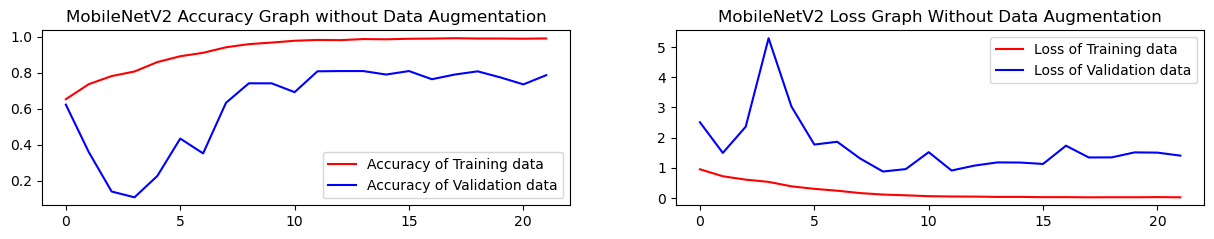

In [20]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(early_stopper.stopped_epoch + 1)

plt.figure(figsize = (15, 5))
plt.subplot(221)
plt.plot(epochs, train_acc, 'r', label = 'Accuracy of Training data')
plt.plot(epochs, val_acc, 'b', label = 'Accuracy of Validation data')
plt.title('MobileNetV2 Accuracy Graph without Data Augmentation')
plt.legend()

plt.subplot(222)
plt.plot(epochs, train_loss, 'r', label = 'Loss of Training data')
plt.plot(epochs, val_loss, 'b', label = 'Loss of Validation data')
plt.title('MobileNetV2 Loss Graph Without Data Augmentation')
plt.legend()
plt.show()

In [21]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test accuracy:', score[1])

141/141 [==============================] - 63s 448ms/step - loss: 0.9148 - accuracy: 0.8080
Test accuracy: 0.8079661726951599


In [22]:
predy = model.predict(testX)
pred = np.argmax(predy, axis = 1)
ground = np.argmax(testy, axis = 1)
print(classification_report(ground, pred))

201/201 [==============================] - 92s 454ms/step
              precision    recall  f1-score   support

           0       0.53      0.29      0.38       326
           1       0.65      0.75      0.70       656
           2       0.60      0.70      0.65       715
           3       0.94      0.92      0.93      3947
           4       0.62      0.62      0.62       773

    accuracy                           0.81      6417
   macro avg       0.67      0.66      0.65      6417
weighted avg       0.81      0.81      0.81      6417



In [23]:
model.save('C:/Users/niko/Quinito/Work/output/model/MobileNetV2.h5')